In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision

In [2]:
#데이터셋 폴더 코드 파일에 위치
data_url='./fire_dataset'

In [3]:
#GPU사용
device = torch.device("cuda:0")

찾은 폴더(클래스): ['0', '1']
전체 이미지 개수: 651장


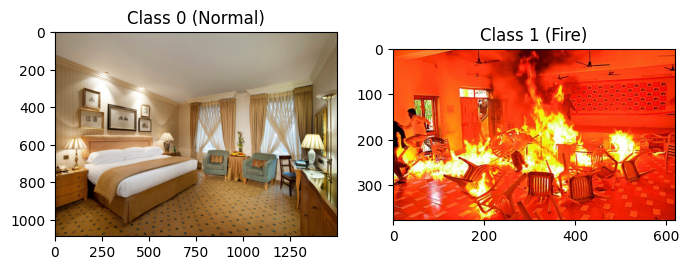

In [4]:
#파일 인식확인
dataset = torchvision.datasets.ImageFolder(root=data_url)
# 클래스 확인
print(f"찾은 폴더(클래스): {dataset.classes}") 
# 0: Normal (정상)
# 1: Fire (화재)

print(f"전체 이미지 개수: {len(dataset)}장")

# 첫 번째 이미지(정상)와 마지막 이미지(화재)꺼내서 보기
img_normal = dataset[0][0]
img_fire = dataset[-1][0]

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img_normal)
ax[0].set_title("Class 0 (Normal)")
ax[1].imshow(img_fire)
ax[1].set_title("Class 1 (Fire)")
plt.show()

In [ ]:
#128x128로 리사이즈
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128, 128)), 
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
#1.데이터셋 불러오기
dataset = torchvision.datasets.ImageFolder(root=data_url, transform=transform)

In [7]:
#1.데이터 로드
#데이터셋 분리:: train 0.8 // validation 0.2
tr_size = int(0.8 * len(dataset))
val_size = len(dataset) - tr_size
ds_tr, ds_val = torch.utils.data.random_split(dataset, [tr_size, val_size])

#데이터 로더, 배치 사이즈 64
dl_tr = torch.utils.data.DataLoader(ds_tr, batch_size=16, shuffle=True)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=16, shuffle=False)

print(f"train: {len(ds_tr)} // validation: {len(ds_val)}")

train: 520 // validation: 131


In [8]:
#2.네트워크 설계
net = torch.nn.Sequential(
    #[Layer 1] Input: 3 x 128 x 128
    torch.nn.Conv2d(3, 32, 3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2), # -> 32 x 64 x 64
    #[Layer 2]
    torch.nn.Conv2d(32, 64, 3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2), # -> 64 x 32 x 32
    #[Layer 3]
    torch.nn.Conv2d(64, 128, 3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2), # -> 128 x 16 x 16
    torch.nn.Flatten(),

    torch.nn.Linear(128 * 16 * 16, 512), 
    torch.nn.ReLU(),
    torch.nn.Linear(512, 2) # 0:Normal, 1:Fire
).to(device)

Epoch 01: loss=0.4552| Train Acc=80.19%
Epoch 02: loss=0.2822| Train Acc=87.88%
Epoch 03: loss=0.2582| Train Acc=89.42%
Epoch 04: loss=0.2028| Train Acc=92.50%
Epoch 05: loss=0.1890| Train Acc=94.04%
Epoch 06: loss=0.1359| Train Acc=95.00%
Epoch 07: loss=0.0949| Train Acc=97.12%
Epoch 08: loss=0.1353| Train Acc=95.19%
Epoch 09: loss=0.1027| Train Acc=96.54%
Epoch 10: loss=0.0475| Train Acc=98.65%
Epoch 11: loss=0.0682| Train Acc=97.69%
Epoch 12: loss=0.1022| Train Acc=97.88%
Epoch 13: loss=0.0263| Train Acc=99.04%
Epoch 14: loss=0.0079| Train Acc=99.81%
Epoch 15: loss=0.0031| Train Acc=100.00%
Training Finished.


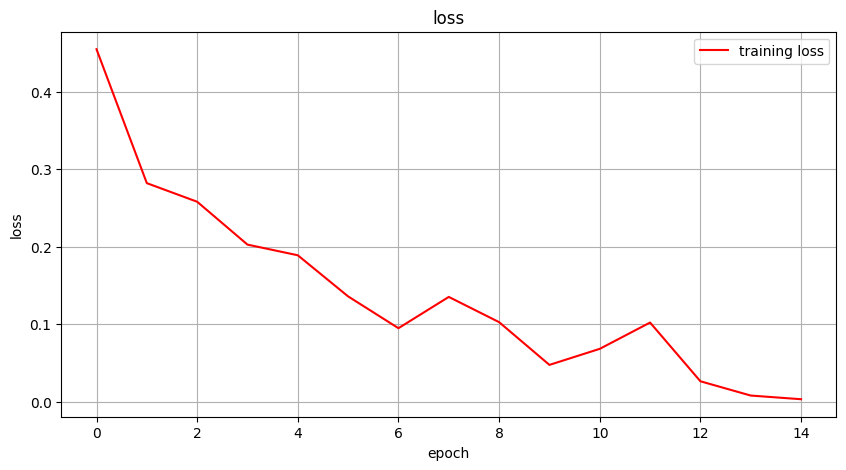

In [9]:
#3.손실함수 및 옵티마이저
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=0.001)

#4.학습
loss_history = []
train_acc_history = []

#epoch: 15회
for epoch in range(15):
    net.train()
    epoch_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for X, y in dl_tr:
        X = X.to(device)
        y = y.to(device)
        
        #업데이트
        y_pred = net(X)
        loss = loss_fn(y_pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()

        predicted = torch.argmax(y_pred, dim=1)         
        train_total += y.size(0)                        
        train_correct += (predicted == y).sum().item()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(dl_tr)
    train_acc = 100 * train_correct / train_total
    loss_history.append(avg_loss)
    train_acc_history.append(train_acc)
    print(f"Epoch {epoch+1:02d}: loss={avg_loss:.4f}| Train Acc={train_acc:.2f}%")

print("Training Finished.")

#5.결과 확인
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='training loss', color='red')
plt.title("loss")
plt.xlabel("epoch") 
plt.ylabel("loss")
plt.grid(True)
plt.legend()
plt.show()

In [10]:
#6.검증 정확도 확인
net.eval()
correct = 0
total = 0

with torch.no_grad():
    for X, y in dl_val:
        X = X.to(device)
        y = y.to(device)
        
        y_pred = net(X)
        predicted = torch.argmax(y_pred, dim=1)
        
        total += y.size(0)
        correct += (predicted == y).sum().item()

print(f"\n검증 정확도: {100 * correct / total:.2f}%")


검증 정확도: 94.66%
